In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#CONVERST MNIST IMGAE FILE INTO TENSOR OF 4-DIMENSIONS(#NO OF IMAGE, HEIGHT, WIDTH, COLOR CHANNEL)
transform = transforms.ToTensor()

In [3]:
#train data
# Specify the location of the MNIST dataset
mnist_location = "C:\\Naman\\Neural_Network\\codemy_neural"
# Load the MNIST dataset from the specified location
train_data = datasets.MNIST(mnist_location, train=True, download=True, transform=transform)
test_data = datasets.MNIST(mnist_location, train=False, download=True, transform=transform)

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Naman\Neural_Network\codemy_neural
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
#create a small batch size for images ... lets's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example in the next case we'll build out the actual model
conv1 = nn.Conv2d(1, 6, 3, 1)#input= 1-image, output- 6 features map, kernel, stride
conv2 = nn.Conv2d(6, 16, 3, 1)#input = 6 outputs of conv1

In [7]:
#Grab 1 Mnist record/image
for i, (x_train, y_train) in enumerate (train_data):
    break

In [8]:
x_train.shape #1 image of 28 *28 size #2D image

torch.Size([1, 28, 28])

In [9]:
x= x_train.view(1,1,28,28) #4D batch, 1 batch of 1 image of 28*28 size

In [10]:
#perform our first convulation
x= F.relu(conv1(x)) #relu for our activation fucntion

In [11]:
x.shape 
#1 single image, 6 is the filters we askeed for, 26*26 image(outer border is drop as we haven't done padding and also in this data we don't need that data)

torch.Size([1, 6, 26, 26])

In [12]:
#pass thru the pooling layer
x = F.max_pool2d(x, 2,2) #kernel of 2 and stride of 2

In [13]:
x.shape
#1 image, 6 feature, 13*13 (26/2 kernel)

torch.Size([1, 6, 13, 13])

In [14]:
#do our second convulation layer
x = F.relu(conv2(x))

In [15]:
x.shape #1imnage, 16 same mention above, 11*11, we didnt set padding we lose 2 pixels arounf the outside of image

torch.Size([1, 16, 11, 11])

In [16]:
#pooling layer
x = F.max_pool2d(x,2,2)
x.shape #11 /2 =5.5 but we have to round down, because u can't invent data to round up

torch.Size([1, 16, 5, 5])

In [17]:
#above are step by step, now we gonna make all in single class

# Model Class
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        #fully connected neurons
        self.fc1 = nn.Linear(5*5*16, 120) #5*5*16 last output, 120 neurons
        self.fc2 = nn.Linear(120, 84) #decreasing neurons downards
        self.fc3 = nn.Linear(84, 10) #10 coz no. of classes we have in our dataset

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
        # Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

        #re-view  to flatten it out
        X = X.view(-1,16*5*5) # negative one so that we can vary the batch size

        #fully connected layer
        X= F.relu(self.fc1(X))
        X= F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


In [18]:
#create an instance of our model
torch.manual_seed(41)
model = Cnn()
model

Cnn(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
#loss function optimizer
criterion = nn.CrossEntropyLoss()
# update the weights of a neural network to minimize the loss 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.1623612344264984
Epoch: 0  Batch: 1200  Loss: 0.16145485639572144
Epoch: 0  Batch: 1800  Loss: 0.5041749477386475
Epoch: 0  Batch: 2400  Loss: 0.13722625374794006
Epoch: 0  Batch: 3000  Loss: 0.005990683101117611
Epoch: 0  Batch: 3600  Loss: 0.35135704278945923
Epoch: 0  Batch: 4200  Loss: 0.005080165341496468
Epoch: 0  Batch: 4800  Loss: 0.002875610953196883
Epoch: 0  Batch: 5400  Loss: 0.054091326892375946
Epoch: 0  Batch: 6000  Loss: 0.00043317434028722346
Epoch: 1  Batch: 600  Loss: 0.011347212828695774
Epoch: 1  Batch: 1200  Loss: 0.2800356149673462
Epoch: 1  Batch: 1800  Loss: 0.0019359525758773088
Epoch: 1  Batch: 2400  Loss: 0.002638503909111023
Epoch: 1  Batch: 3000  Loss: 0.019003523513674736
Epoch: 1  Batch: 3600  Loss: 0.3060741126537323
Epoch: 1  Batch: 4200  Loss: 0.012078829109668732
Epoch: 1  Batch: 4800  Loss: 0.00035228414344601333
Epoch: 1  Batch: 5400  Loss: 0.0002664433850441128
Epoch: 1  Batch: 6000  Loss: 0.2017184942960739
Epoch: 2 

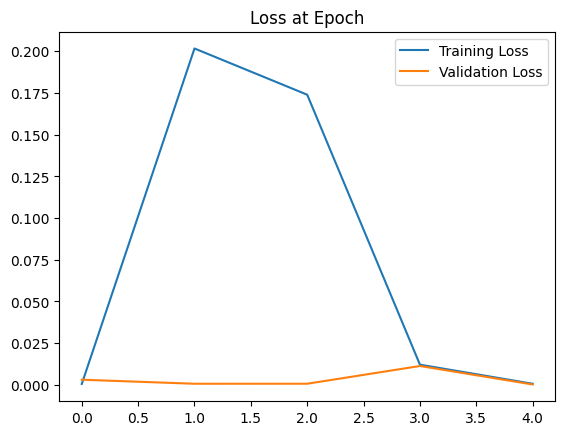

In [21]:

# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
     

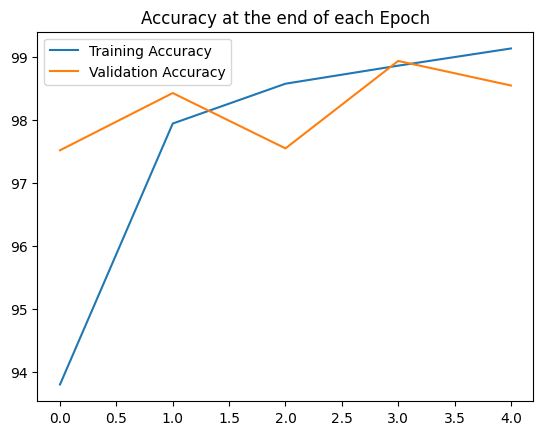

In [22]:

# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [23]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [24]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()
     

In [25]:

# Did for correct
correct.item()/len(test_data)*100

98.55000000000001

In [26]:

# Grab an image
test_data[1978] # Tensor with an image in it...at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [27]:
# Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [28]:
# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

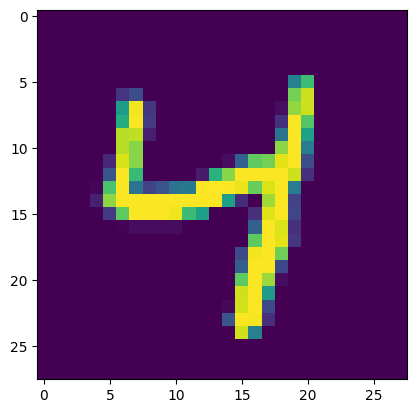

In [29]:

# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [30]:

# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image
     

In [31]:
# Check the new prediction...get probabilities
new_prediction

tensor([[-2.1501e+01, -1.7466e+01, -2.3097e+01, -2.8861e+01, -4.7684e-07,
         -1.8688e+01, -1.5957e+01, -2.1867e+01, -2.0897e+01, -1.4790e+01]])

In [32]:

new_prediction.argmax()

tensor(4)